## Calculate utterance related features

In [ ]:
import pandas as pd
from pathlib import Path

TRANSCRIPT_DIR = Path("transcript_files/")

# Load all transcript files
transcript_files = sorted(TRANSCRIPT_DIR.glob("*_TRANSCRIPT.csv"))
all_summaries = []

for file_path in transcript_files:
    try:
        # Split the fields by tab and skip the first row
        df = pd.read_csv(file_path, sep="\t", header=None, names=["start_time", "stop_time", "speaker", "value"]).iloc[1:]
        
        # Transform the start_time and stop_time to float
        df["start_time"] = df["start_time"].astype(float)
        df["stop_time"] = df["stop_time"].astype(float)
        df["duration"] = df["stop_time"] - df["start_time"]

        # Extract features
        summary = {
            "Participant_ID": int(file_path.stem.split("_")[0]),
            "Num_Utterances_Ellie": (df['speaker'] == 'Ellie').sum(),
            "Num_Utterances_Participant": (df['speaker'] == 'Participant').sum(),
            "Total_Duration_Ellie": df.loc[df['speaker'] == 'Ellie', 'duration'].sum(),
            "Total_Duration_Participant": df.loc[df['speaker'] == 'Participant', 'duration'].sum(),
            "Avg_Utterance_Duration_Ellie": df.loc[df['speaker'] == 'Ellie', 'duration'].mean(),
            "Avg_Utterance_Duration_Participant": df.loc[df['speaker'] == 'Participant', 'duration'].mean(),
        }

        speakers = df['speaker'].values
        
        # Calculate the number of conversational turns between Ellie and the Participant.
        # A turn is defined as a transition from Ellie speaking to the Participant speaking.
        summary['Num_Turns'] = sum((speakers[i] == 'Ellie' and speakers[i+1] == 'Participant') for i in range(len(speakers)-1))

        all_summaries.append(summary)

    except Exception as e:
        print(f"[!] Error processing {file_path.name}: {e}")

# Create a DataFrame from the summaries
utt_feature_df = pd.DataFrame(all_summaries)
utt_cols = utt_feature_df.columns[1:]

[!] Error processing ._487_TRANSCRIPT.csv: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte


In [12]:
utt_feature_df

,Participant_ID,Num_Utterances_Ellie,Num_Utterances_Participant,Total_Duration_Ellie,Total_Duration_Participant,Avg_Utterance_Duration_Ellie,Avg_Utterance_Duration_Participant,Num_Turns
0,300,87,87,140.840,155.760,1.618851,1.790345,58
1,301,77,104,97.950,475.440,1.272078,4.571538,49
2,302,89,97,113.393,208.933,1.274079,2.153948,53
3,303,88,103,148.230,642.930,1.684432,6.242039,57
4,304,100,104,164.100,362.600,1.641000,3.486538,75
...,...,...,...,...,...,...,...,...
184,488,64,138,135.227,422.490,2.112922,3.061522,39
185,489,85,117,163.259,168.810,1.920694,1.442821,67
186,490,77,97,149.917,185.900,1.946974,1.916495,51
187,491,85,146,163.156,413.580,1.919482,2.832740,58


In [30]:
utt_feature_df.describe()

,Participant_ID,Num_Utterances_Ellie,Num_Utterances_Participant,Total_Duration_Ellie,Total_Duration_Participant,Avg_Utterance_Duration_Ellie,Avg_Utterance_Duration_Participant,Num_Turns
count,189.000000,189.000000,189.000000,189.000000,189.000000,186.000000,189.000000,189.000000
mean,395.947090,79.359788,171.433862,138.837915,465.619868,1.783299,2.766578,56.423280
std,56.117822,17.626071,75.070549,28.262670,235.769867,0.293228,0.979835,13.436244
min,300.000000,0.000000,42.000000,0.000000,62.230000,1.031296,1.131455,0.000000
25%,348.000000,71.000000,118.000000,127.778000,295.760000,1.500038,2.119902,49.000000
50%,396.000000,80.000000,155.000000,142.310000,430.920000,1.888965,2.581485,56.000000
75%,444.000000,89.000000,211.000000,154.646000,591.390000,2.009469,3.296306,64.000000
max,492.000000,121.000000,386.000000,214.678000,1282.820000,2.303188,7.215654,99.000000


### Sessions with special notes:
- 373 – there is an interruption around 5:52-7:00, the confederate enters the room to fix a minor 
technical issue, the session continuous and completes . 
- 444 – there is an interruption around 4:46-6:27, the participant’s phone rings and the 
confederate enters the room to help them turn it off. Session continuous and completes. 
- 451, 458, 480 – sessions are technically complete, but missing Ellie (the virtual human) part of the 
transcripts. Participant transcripts are still included, but without the interviewer questions.
- 402 – video recording is cut ~2min before the end of the conversation. 

## Merge with split data containing demographic and label information

In [26]:
CWD = Path("downloads/")

train = pd.read_csv(CWD / "train_split_Depression_AVEC2017.csv")
dev = pd.read_csv(CWD / "dev_split_Depression_AVEC2017.csv")
# test = pd.read_csv(CWD / "test_split_Depression_AVEC2017.csv")

test = pd.read_csv(CWD / "full_test_split.csv")
test.rename(columns={"PHQ_Score": "PHQ8_Score", "PHQ_Binary": "PHQ8_Binary"}, inplace=True)

In [27]:
# Add a 'split' column to each dataframe
train['Split'] = 'train'
dev['Split'] = 'dev'
test['Split'] = 'test'

# Concatenate the dataframes
combined_df = pd.concat([train, dev, test])

# Sort by Participant_ID
combined_df = combined_df.sort_values(by='Participant_ID').reset_index(drop=True)

# Reorder columns
use_cols = ['Split', 'Participant_ID', 'Gender', 'PHQ8_Binary', 'PHQ8_Score']
columns_order = use_cols + [col for col in combined_df.columns if col not in use_cols]
combined_df = combined_df[columns_order]

combined_df

,Split,Participant_ID,Gender,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,test,300,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,test,301,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dev,302,1,0,4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,train,303,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train,304,0,0,6,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,train,488,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,dev,489,1,0,3,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
186,dev,490,1,0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
187,train,491,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
# Merge combined_df and utt_feature_df on Participant_ID
merged_df = pd.merge(combined_df, utt_feature_df, on='Participant_ID', how='inner')

# Display the merged dataframe
merged_df

,Split,Participant_ID,Gender,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Num_Utterances_Ellie,Num_Utterances_Participant,Total_Duration_Ellie,Total_Duration_Participant,Avg_Utterance_Duration_Ellie,Avg_Utterance_Duration_Participant,Num_Turns
0,test,300,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87,87,140.840,155.760,1.618851,1.790345,58
1,test,301,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,104,97.950,475.440,1.272078,4.571538,49
2,dev,302,1,0,4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,89,97,113.393,208.933,1.274079,2.153948,53
3,train,303,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88,103,148.230,642.930,1.684432,6.242039,57
4,train,304,0,0,6,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,100,104,164.100,362.600,1.641000,3.486538,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,train,488,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,138,135.227,422.490,2.112922,3.061522,39
185,dev,489,1,0,3,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,85,117,163.259,168.810,1.920694,1.442821,67
186,dev,490,1,0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,77,97,149.917,185.900,1.946974,1.916495,51
187,train,491,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,85,146,163.156,413.580,1.919482,2.832740,58


In [24]:
# Define the full range of Participant_IDs
full_range = set(range(300, 493))

# Find missing Participant_IDs
missing_ids = full_range - set(merged_df['Participant_ID'])
print("Missing Participants (Excluded sessions):", sorted(missing_ids))

Missing Participants (Excluded sessions): [342, 394, 398, 460]


In [35]:
# Drop the specified columns from combined_df
columns_to_drop = ['PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 
                   'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']
df = merged_df.drop(columns=columns_to_drop)

# Create the 'data' folder if it doesn't exist
Path("data").mkdir(exist_ok=True)

# Save the DataFrame as a CSV file in the 'data' folder
df.to_csv("data/df.csv", index=False)

## Simple EDA

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot(data, columns, title, hue=None):
    """
    Plots a boxplot for the specified columns in the DataFrame.

    Parameters:
    - data (DataFrame): A pandas DataFrame containing the data to plot.
    - columns (list): A list of column names to include in the boxplot.
    - title (str): The title of the plot.
    """
    if hue is None:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=data[columns], palette="pastel")
    else:
        # Melt the dataframe to long format for seaborn
        melted_data = data.melt(id_vars=hue, value_vars=columns, var_name="Feature", value_name="Value")
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=melted_data, x="Feature", y="Value", hue=hue, palette="pastel")
        
    plt.title(title)
    plt.show()

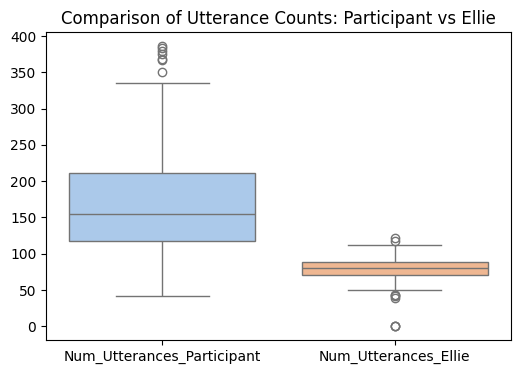

In [79]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie")

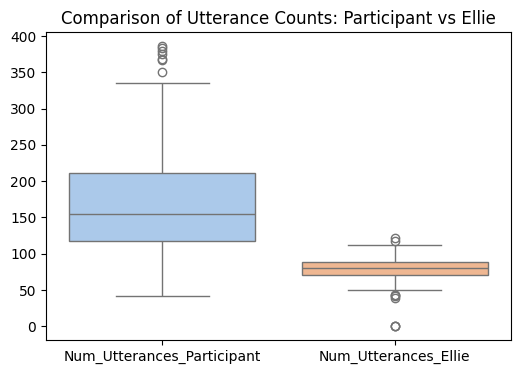

In [80]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie")

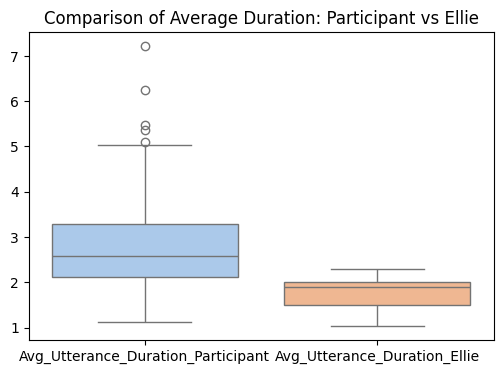

In [82]:
plot_boxplot(df,
             columns=['Avg_Utterance_Duration_Participant', 'Avg_Utterance_Duration_Ellie'],
             title="Comparison of Average Duration: Participant vs Ellie")

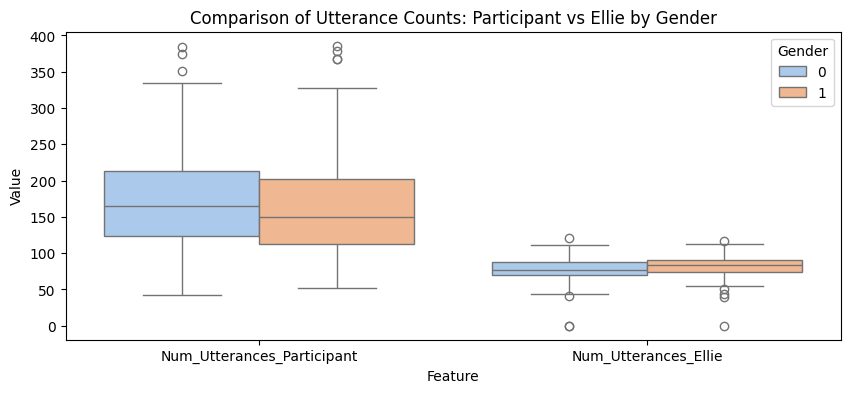

In [85]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie by Gender",
             hue='Gender')

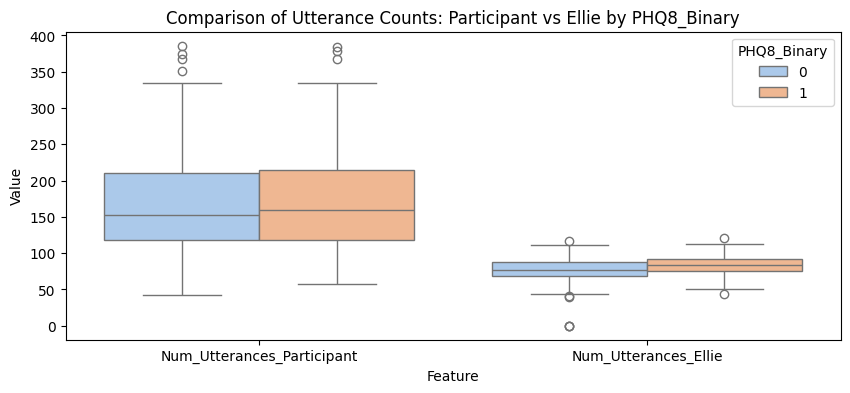

In [86]:
plot_boxplot(df,
             columns=['Num_Utterances_Participant', 'Num_Utterances_Ellie'],
             title="Comparison of Utterance Counts: Participant vs Ellie by PHQ8_Binary",
             hue='PHQ8_Binary')

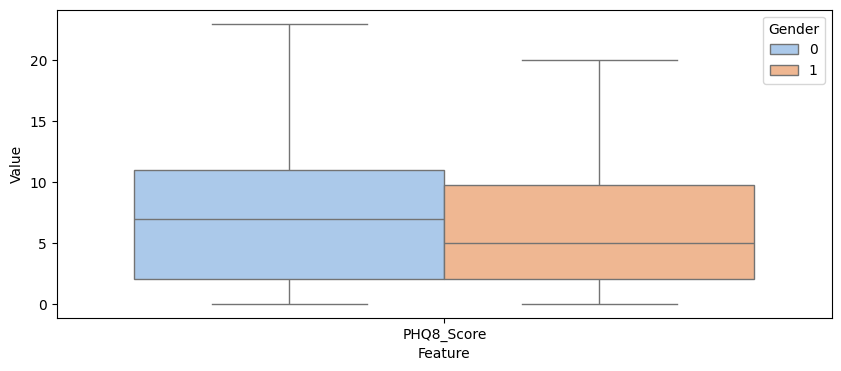

In [87]:
plot_boxplot(df,
             columns=['PHQ8_Score'],
             title="",
             hue='Gender')

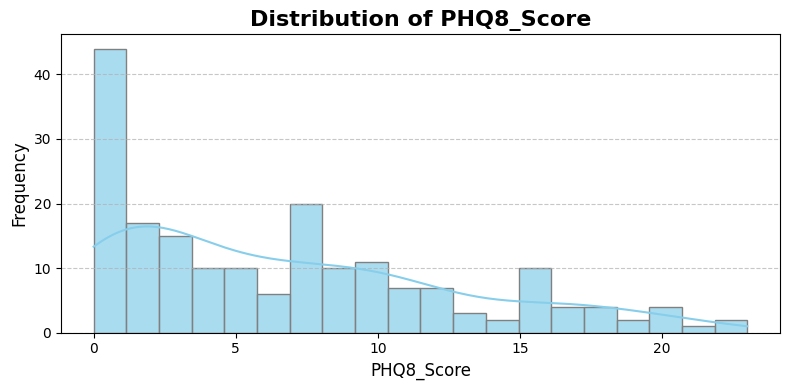

In [55]:
# Distribution of PHQ8_Score with enhanced visualization (no border)
plt.figure(figsize=(8, 4))
sns.histplot(df['PHQ8_Score'], bins=20, kde=True, color='skyblue', alpha=0.7, edgecolor='gray')
plt.title("Distribution of PHQ8_Score", fontsize=16, fontweight='bold')
plt.xlabel("PHQ8_Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Visualization

In [47]:
import os
from pathlib import Path
import numpy as np
import librosa
import librosa.display
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

# audio file path
WAV_DIR = Path("wav_files")

def load_audio(uid: str, sr_target=16000, max_len_sec=60):
    wav_path = WAV_DIR / f"{uid}_AUDIO.wav"
    y, sr = librosa.load(wav_path, sr=sr_target)
    if len(y) > sr * max_len_sec:
        y = y[:sr * max_len_sec]
    return y, sr

def plot_audio(uid: str):
    y, sr = load_audio(uid)
    t = np.linspace(0, len(y) / sr, num=len(y))

    S = librosa.stft(y, n_fft=1024, hop_length=512)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Downsample
    S_db_small = S_db[::2, ::2]
    times = librosa.frames_to_time(np.arange(S_db_small.shape[1]) * 2, sr=sr)
    freqs = librosa.fft_frequencies(sr=sr)[::2]

    fig = make_subplots(rows=2, cols=1, shared_xaxes=False,
                        subplot_titles=("Waveform", "Log Spectrogram"))

    fig.add_trace(go.Scatter(x=t, y=y, mode="lines", name="Waveform"), row=1, col=1)

    fig.add_trace(go.Heatmap(
        z=S_db_small, x=times, y=freqs, colorscale='Viridis',
        colorbar=dict(title="dB")), row=2, col=1)

    fig.update_layout(
        height=700, title_text=f"Participant {uid} Audio Visualization",
        xaxis2_title="Time (s)", yaxis2_title="Frequency (Hz)",
        template="ggplot2"
    )
    fig.show()


In [49]:
# # make dropdown widget for selecting uid
# uids = sorted([f.stem.split("_")[0] for f in WAV_DIR.glob("*_AUDIO.wav")])
# uid_selector = widgets.Dropdown(options=uids, value=uids[0], description="UID:")

# def on_update(uid):
#     plot_audio(uid)

In [50]:
# interactive_plot = widgets.interactive(on_update, uid=uid_selector)
# display(interactive_plot)